In [ ]:
try:
  from future.utils import iteritems
except:
  !pip install future
  from future.utils import iteritems

In [13]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 735.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f9bdf28aa6ea9afad7e7c5b2994ac77384ac8c7e4d49729d4c94394748bfa23d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [41]:
import numpy as np
import pandas as pd
import spacy
import os
import matplotlib.pyplot as plt
from spacy import displacy
from future.utils import iteritems
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import AdamW
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow.keras.backend as K

In [42]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ner-data/ner.csv


In [43]:
df = pd.read_csv("/kaggle/input/ner-data/ner.csv",
                 encoding = "ISO-8859-1",
                 on_bad_lines="skip")
df = df.ffill()

In [44]:
df.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [45]:
df = df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'shape'],axis=1)

In [46]:
df

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O
...,...,...,...,...
1050790,PRP,47959.0,they,O
1050791,VBD,47959.0,responded,O
1050792,TO,47959.0,to,O
1050793,DT,47959.0,the,O


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   pos           1050795 non-null  object 
 1   sentence_idx  1050795 non-null  float64
 2   word          1050795 non-null  object 
 3   tag           1050795 non-null  object 
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


In [48]:
df.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [11]:
words = list(set(df['word'].values))
words.append("ENDPAD")
pos_tags = list(set(df['pos'].values))
tags = list(set(df['tag'].values))
words_encoded = {word: i for i, word in enumerate(words)}
pos_encoded = {pos_tag: i for i, pos_tag in enumerate(pos_tags)}
ner_tag_encoded = {tag: i for i, tag in enumerate(tags)}
get_encoded_tag = {tag: i for i, tag in iteritems(ner_tag_encoded)}

In [12]:
def preprocess(df):
    def combine(group):
       return [(word, pos, tag) for word, pos, tag in zip(group['word'].values.tolist(),
                                                          group['pos'].values.tolist(),
                                                          group['tag'].values.tolist())]

    df=df.groupby(['sentence_idx']).apply(combine, include_groups = True).reset_index().rename(columns={0:'combined'})
    df['sentence']=df['combined'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
    df['pos']=df['combined'].apply(lambda sentence:" ".join([s[1] for s in sentence]))
    df['tag']=df['combined'].apply(lambda sentence:" ".join([s[2] for s in sentence]))
    df['tag_list']=df['tag'].apply(lambda tag: tag.split())
    df.drop("combined", inplace=True, axis=1)
    return df

In [13]:
df_preprocessed = preprocess(df)
df_preprocessed.head()

/tmp/ipykernel_34/124511487.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df=df.groupby(['sentence_idx']).apply(combine, include_groups = True).reset_index().rename(columns={0:'combined'})


,sentence_idx,sentence,pos,tag,tag_list
0,1.0,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,2.0,Families of soldiers killed in the conflict jo...,NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS ...,O O O O O O O O O O O O O O O O O O B-per O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,3.0,They marched from the Houses of Parliament to ...,PRP VBD IN DT NNS IN NN TO DT NN IN NNP NNP . ...,O O O O O O O O O O O B-geo I-geo O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,4.0,"Police put the number of marchers at 10,000 wh...",NNS VBD DT NN IN NNS IN CD IN NNS VBD PRP VBD ...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,5.0,The protest comes on the eve of the annual con...,DT NN VBZ IN DT NN IN DT JJ NN IN NNP POS VBG ...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."


In [14]:
sentences_list=df_preprocessed['sentence'].tolist()
tags_list=df_preprocessed['tag_list'].tolist()
for i, sentence in enumerate(sentences_list):
    sentences_list[i] = sentences_list[i].split()
print(sentences_list[0])
print('\n',tags_list[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']

 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [15]:
encoded_tags=[[ner_tag_encoded[w] for w in tag] for tag in tags_list]
encoded_sentences=[[words_encoded[w] for w in sentence] for sentence in sentences_list]

In [16]:
max_len = max(len(sentence) for sentence in encoded_sentences)
print(max_len)
padded_encoded_sentences=pad_sequences(maxlen=max_len,
                                       sequences=encoded_sentences,
                                       padding="post",
                                       value=len(words)-1)
padded_encoded_tags=pad_sequences(maxlen=max_len,
                                  sequences=encoded_tags,
                                  padding="post",
                                  value=ner_tag_encoded['O'])

140


In [17]:
target = [to_categorical(i,num_classes = len(tags)) for i in padded_encoded_tags]
print("Shape of categorical labels for first input sequence: ",target[0].shape)
print("Vocabulary size: ",len(words))

Shape of categorical labels for first input sequence:  (140, 17)
Vocabulary size:  30172


In [18]:
X_train, X_test, y_train, y_test = train_test_split(padded_encoded_sentences,
                                                    target,
                                                    test_size=0.2)

In [19]:
embedding_dim=128

input = Input(shape=(max_len,))
model = Embedding(input_dim=len(words), output_dim=embedding_dim)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)
model = Model(input, out)

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lstm_model_weights.weights.h5")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 140, 128)       │     3,862,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 140, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129,553 (15.75 MB)

 Trainable params: 4,129,553 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model.compile(optimizer=AdamW(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=[CategoricalAccuracy(), f1_score_metric, precision_metric, recall_metric])

history = model.fit(X_train, np.array(y_train),
                    batch_size=256,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - categorical_accuracy: 0.9125 - f1_score_metric: 0.8546 - loss: 0.4503 - precision_metric: 0.8732 - recall_metric: 0.8393 - val_categorical_accuracy: 0.9681 - val_f1_score_metric: 0.9727 - val_loss: 0.1193 - val_precision_metric: 0.9785 - val_recall_metric: 0.9670
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - categorical_accuracy: 0.9708 - f1_score_metric: 0.9757 - loss: 0.1042 - precision_metric: 0.9849 - recall_metric: 0.9668 - val_categorical_accuracy: 0.9807 - val_f1_score_metric: 0.9821 - val_loss: 0.0716 - val_precision_metric: 0.9935 - val_recall_metric: 0.9709
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - categorical_accuracy: 0.9832 - f1_score_metric: 0.9843 - loss: 0.0616 - precision_metric: 0.9945 - recall_metric: 0.9742 - val_categorical_accuracy: 0.9876 - val_f1_score_metric: 0.9877 - val_loss: 0.0454 - val_precision_metric: 0.9934 - val_recall_metric: 0.9820
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106m

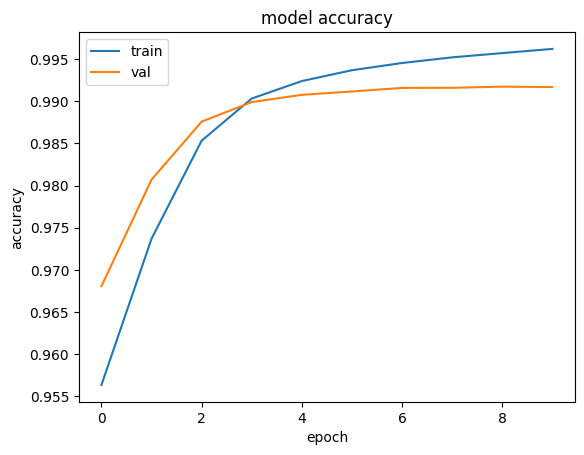

In [22]:

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

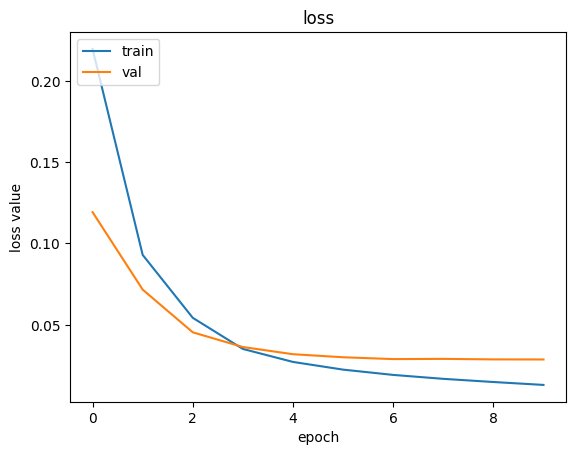

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

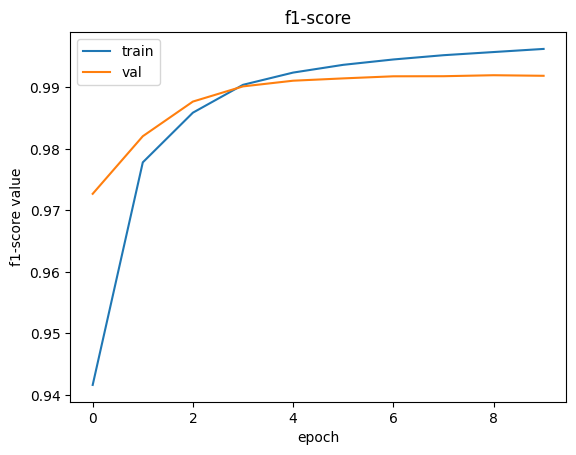

In [24]:
plt.plot(history.history['f1_score_metric'])
plt.plot(history.history['val_f1_score_metric'])

plt.title('f1-score')
plt.ylabel('f1-score value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.evaluate(X_test, np.asarray(y_test))

220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - categorical_accuracy: 0.9922 - f1_score_metric: 0.9925 - loss: 0.0262 - precision_metric: 0.9936 - recall_metric: 0.9914


[0.0259022805839777,
 0.9922152757644653,
 0.9925007224082947,
 0.9936110973358154,
 0.9913933277130127]

In [26]:
preds=model.predict(X_test)

220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [27]:
def convert_tags(test_data, preds, actual_preds):
    pred_tokens = []
    actual_tags = []
    pred_tags = []
    for i, data in enumerate(test_data):
        tokens = [words[x] if x != 0 else '<PAD>' for x in list(data)]
        actual_tags.extend([get_encoded_tag[x] for x in list(actual_preds[i])])
        pred_tags.extend([get_encoded_tag[x] for x in list(preds[i])])
        pred_tokens.extend(tokens)
    non_pad_indices = [i for i, token in enumerate(pred_tokens) if token != '<PAD>']
    actual_tags = [actual_tags[i] for i in non_pad_indices]
    pred_tags = [pred_tags[i] for i in non_pad_indices]
    return pred_tags, actual_tags

In [28]:
def get_labels(preds, labels):
    return np.argmax(preds, axis = 2), np.argmax(labels, axis = 2)

In [29]:
preds_argmax, y_test_argmax = get_labels(preds, y_test)
y_pred_converted, y_test_converted = convert_tags(X_test,
                                                  preds_argmax,
                                                  np.array(y_test_argmax))

In [30]:
print(classification_report(y_test_converted, y_pred_converted))
f1Score = f1_score(y_test_converted, y_pred_converted, average='weighted')
print("f1 score on testing set: ", f1Score)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        96
       B-eve       0.33      0.02      0.03        63
       B-geo       0.86      0.86      0.86      7415
       B-gpe       0.96      0.91      0.94      3148
       B-nat       0.00      0.00      0.00        47
       B-org       0.74      0.72      0.73      4078
       B-per       0.85      0.75      0.80      3397
       B-tim       0.90      0.86      0.88      3999
       I-art       0.00      0.00      0.00        48
       I-eve       0.00      0.00      0.00        67
       I-geo       0.80      0.74      0.77      1431
       I-gpe       1.00      0.07      0.14        40
       I-nat       0.00      0.00      0.00        21
       I-org       0.72      0.78      0.75      3327
       I-per       0.85      0.82      0.83      3445
       I-tim       0.76      0.69      0.72      1165
           O       1.00      1.00      1.00    953251

    accuracy              

In [31]:
for i in range(0, 5):
  text = X_test[i]
  p = model.predict(np.array([text]))
  p = np.argmax(p, axis=-1)
  gt = np.argmax(y_test[i], axis=-1)
  print("Test sentence:", i+1)
  print("{:14} {:5}: \t{}".format("Word",
                                  "True NER Labels",
                                  "Predicted NER labels"))
  for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
      if words[w] != "ENDPAD":
          print("{:14} {:5} \t\t\t{}".format(words[w],
                                             get_encoded_tag[gt[idx]],
                                             tags[pred]))
  print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test sentence: 1
Word           True NER Labels: 	Predicted NER labels
Other          O     			O
graves         O     			O
have           O     			O
been           O     			O
found          O     			O
with           O     			O
the            O     			O
bodies         O     			O
of             O     			O
thousands      O     			O
of             O     			O
anti-communist O     			O
mujahedin      O     			O
fighters       O     			O
.              O     			O
Other          O     			O
graves         O     			O
have           O     			O
been           O     			O
found          O     			O
with           O     			O
the            O     			O
bodies         O     			O
of             O     			O
thousands      O     			O
of             O     			O
anti-communist O     			O
mujahedin      O     			O
fighters       O     			O
.              O     			O


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test sentence: 2
Word           True NER Labels: 	Predicted NER labels


In [32]:
# Try to get this working

# # nlp = spacy.load("en_core_web_sm")
# from keras.models import model_from_json
# # Load the saved model architecture from JSON
# with open("lstm_model.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# loaded_model = model_from_json(loaded_model_json)
# # loaded_model.load_weights("lstm_model_weights.weights.h5")

# Visualize NER tagging on test set examples with spacy
# nlp = spacy.load("en_core_web_sm")
# nlp_entity = spacy.load("lstm_model.json")
# nlp.add_pipe("ner", source=loaded_model)
# for i in range(0, 5):
#   text = X_test[i]
#   spacy_str = []
#   for w in text:
#     if words[w] != "ENDPAD":
#       spacy_str.append(words[w])
#   spacy_str = ' '.join(spacy_str)
#   doc = nlp(str(spacy_str))
#   print("{}. ".format(i+1))
#   displacy.render(doc, style="ent")
#   print("\n")

In [49]:
df.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [50]:
df.rename(columns = {"sentence_idx": "sentence_id" ,"word": "words", "tag": "labels"},inplace = True)

In [51]:
df["labels"] = df["labels"].str.upper()
df.head()

,pos,sentence_id,words,labels
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [52]:
X = df[["sentence_id", "words"]]
Y = df["labels"]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [53]:
from simpletransformers.ner import NERArgs,NERModel
from sklearn.metrics import accuracy_score

In [54]:
labels = df["labels"].unique().tolist()
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'B-ART',
 'I-ART',
 'I-PER',
 'I-GPE',
 'I-TIM',
 'B-NAT',
 'B-EVE',
 'I-EVE',
 'I-NAT']

In [55]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 32
args.eval_batch_size = 32

In [59]:
distil_model = NERModel("distilbert", "distilbert-base-uncased", labels=labels, args=args)
distil_model.train_model(train_data=train_data, eval_data=test_data, acc = accuracy_score)
result, model_outputs, preds_list= distil_model.eval_model(test_data)
result

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1080 [00:00<?, ?it/s]

{'eval_loss': 0.42862779806471535,
 'precision': 0.3684210526315789,
 'recall': 0.19064829455613283,
 'f1_score': 0.251270600744285}

In [60]:
bert_model = NERModel("bert", "bert-base-uncased", labels=labels, args=args)
bert_model.train_model(train_data=train_data, eval_data=test_data, acc = accuracy_score)
result, model_outputs, preds_list= bert_model.eval_model(test_data)
result

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1080 [00:00<?, ?it/s]

{'eval_loss': 0.4251866347397919,
 'precision': 0.36517560919803227,
 'recall': 0.20600858369098712,
 'f1_score': 0.2634152379773473}

### bert-base-uncased have maximum f1 so using bert-base-uncased insted of distilbert-base-uncased

In [61]:
prediction, model_output = bert_model.predict(["Apple company, and I live in USA"])
prediction

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[[{'Apple': 'B-GEO'},
  {'company,': 'O'},
  {'and': 'O'},
  {'I': 'B-GEO'},
  {'live': 'O'},
  {'in': 'O'},
  {'USA': 'B-GEO'}]]